# Experimenting to fix cracks & folds in basil  
Using the Optimizer to fix cracks & folds in basil

In [1]:
!mkdir -p ~/.cloudvolume/secrets
!cp /notebooks/*.json ~/.cloudvolume/secrets/
!pip install cloud-volume
!pip install scikit-image

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from cloudvolume import CloudVolume
from cloudvolume.lib import Bbox
import numpy as np
import torch
from torch.autograd import Variable
from optimize import Optimizer
from copy import deepcopy
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img_mip = 2
mask_mip = 5
src = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/unmasked", mip=img_mip, 
                                                                parallel=2, fill_missing=True)
cracks = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/mask/crack_detector_v3", mip=mask_mip,
                                                                 parallel=2, fill_missing=True)
folds = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/mask/fold_detector_v1", mip=mask_mip,
                                                                 parallel=2, fill_missing=True)

In [4]:
flow = Optimizer(ndownsamples=5, currn=5, avgn=20, lambda1=0.5, lr=0.1, eps=0.001, min_iter=100, max_iter=5000)

In [5]:
full_offset = np.array([102716, 107077, 526])
full_size = np.array([2048, 2048, 1])
full_bbox = Bbox(full_offset, full_offset+full_size)
src_bbox = Bbox.from_slices(src.slices_from_global_coords(full_bbox))
dst_bbox = src_bbox + [0,0,1]
mask_bbox = Bbox.from_slices(folds.slices_from_global_coords(full_bbox))
print(src_bbox)
print(dst_bbox)
print(mask_bbox)

Bbox([25679, 26769, 526],[26191, 27281, 527])
Bbox([25679, 26769, 527],[26191, 27281, 528])
Bbox([3209, 3346, 526],[3273, 3410, 527])


In [6]:
dst = CloudVolume("gs://neuroglancer/basil_v0/son_of_alignment/v3.04/optimizer_tests/v01_no_mask", mip=img_mip, 
                        info=src.info, parallel=False, fill_missing=True, non_aligned_writes=True, cdn_cache=False)
dst.commit_info();

In [7]:
dst[dst_bbox.to_slices()] = src[dst_bbox.to_slices()]

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Rechunking image: 0it [00:00, ?it/s]
Uploading: 0it [00:00, ?it/s]
Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]

Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]


Rechunking image:   0%|          | 0/1 [00:00<?, ?it/s]



Rechunking image: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]



In [8]:
src_img = src[src_bbox.to_slices()][:,:,0,0] / 255.0
dst_img = src[dst_bbox.to_slices()][:,:,0,0] / 255.0

fold = folds[mask_bbox.to_slices()][:,:,0,0] / 255.0
crack = cracks[mask_bbox.to_slices()][:,:,0,0] / 255.0
mask = resize(np.minimum(fold, crack), src_bbox.size3()[:2])

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


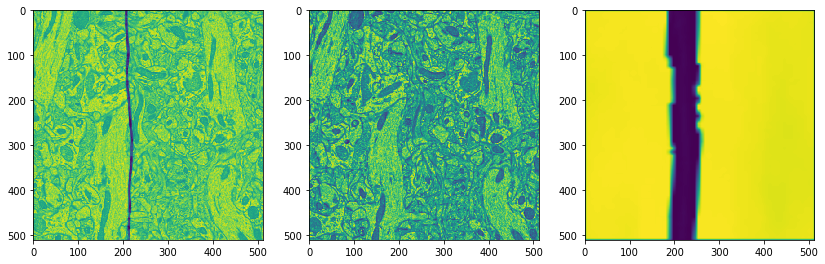

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,8), facecolor='white')
axes[0].imshow(src_img)
axes[1].imshow(dst_img)
axes[2].imshow(mask)
plt.show()

In [10]:
field = flow.process(src_img, dst_img, np.zeros_like(dst_img))
pred = flow.render(src_img, field)
dst[src_bbox.to_slices()] = (pred[0,0,:,:,np.newaxis, np.newaxis]*255).astype(np.uint8)

(512, 512) (512, 512)
4
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


ZeroDivisionError: float division by zero